In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [27]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('D:/Resume_matcher/data/fake_job_postings.csv')
df.shape
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


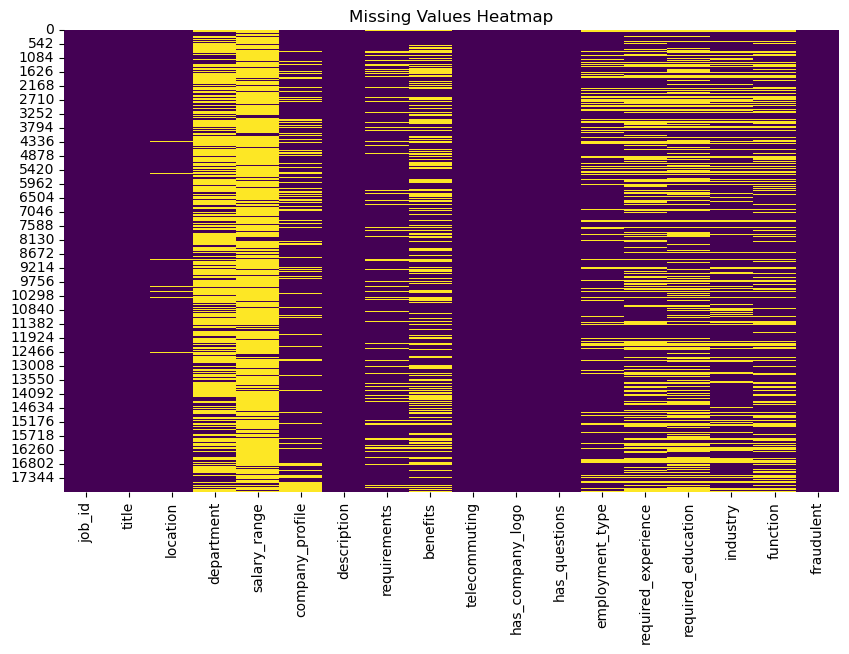

In [3]:
df.isnull().sum().sort_values(ascending=False)

# Visualize missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [14]:
# Fill missing with a placeholder or strategy
df.fillna("missing", inplace=True)

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Feature matrix and target
X = df.drop(columns=['fraudulent', 'job_id'])  # drop ID & target
y = df['fraudulent']

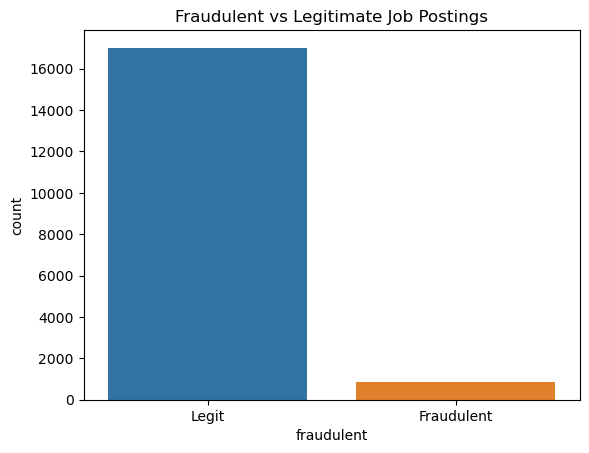

Fraudulent postings: 4.84%


In [4]:
sns.countplot(data=df, x='fraudulent')
plt.title('Fraudulent vs Legitimate Job Postings')
plt.xticks([0, 1], ['Legit', 'Fraudulent'])
plt.show()

fraud_pct = df['fraudulent'].value_counts(normalize=True)[1] * 100
print(f"Fraudulent postings: {fraud_pct:.2f}%")

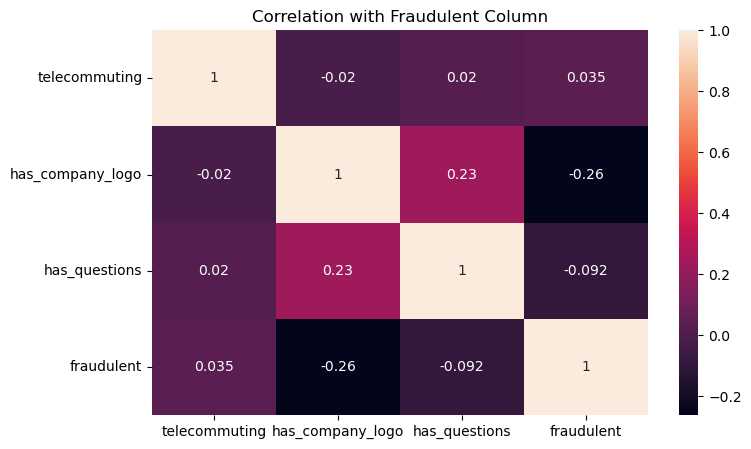

In [5]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].corr(), annot=True)
plt.title("Correlation with Fraudulent Column")
plt.show()

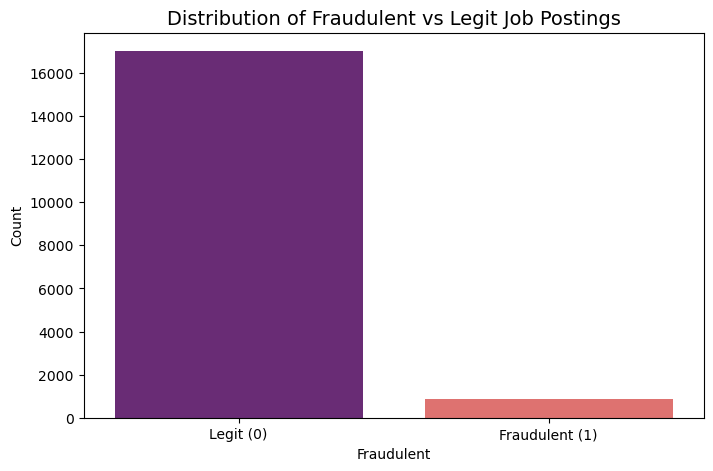

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='fraudulent', data=df, palette='magma')
plt.title("Distribution of Fraudulent vs Legit Job Postings", fontsize=14)
plt.xticks([0, 1], ['Legit (0)', 'Fraudulent (1)'])
plt.xlabel("Fraudulent")
plt.ylabel("Count")
plt.show()

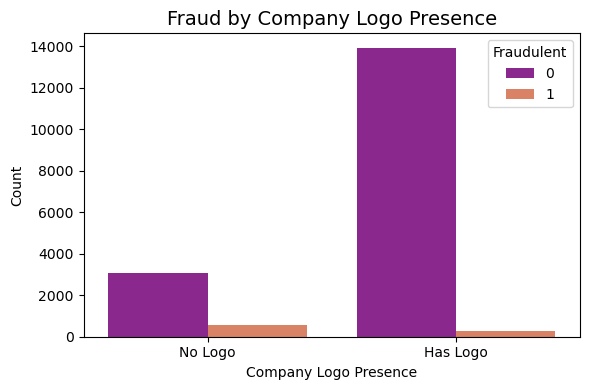

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='plasma')
plt.title('Fraud by Company Logo Presence', fontsize=14)
plt.xticks([0,1], ['No Logo', 'Has Logo'])
plt.xlabel('Company Logo Presence')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

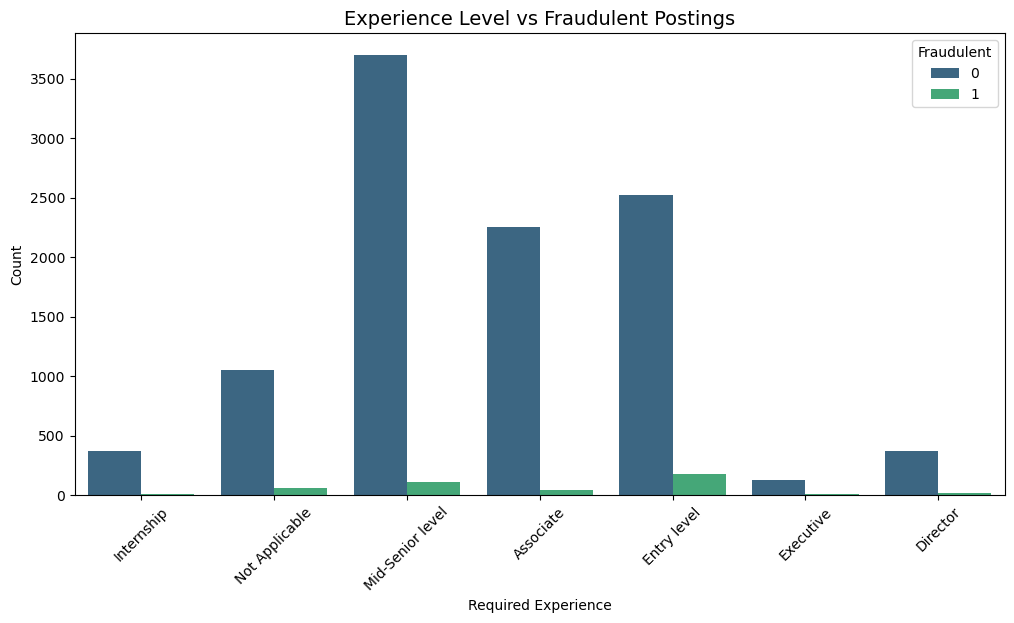

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='required_experience', hue='fraudulent', palette='viridis')
plt.title("Experience Level vs Fraudulent Postings", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Required Experience")
plt.ylabel("Count")
plt.legend(title="Fraudulent")
plt.show()

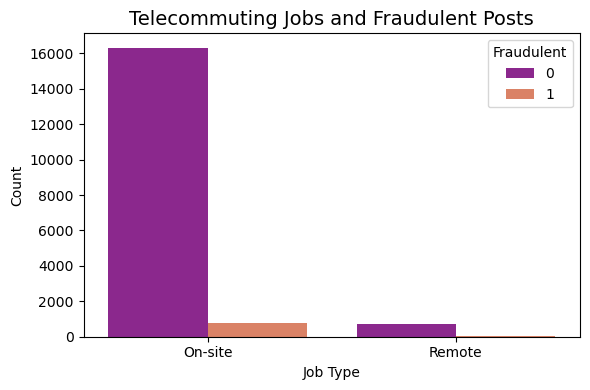

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='telecommuting', hue='fraudulent', palette='plasma')
plt.title('Telecommuting Jobs and Fraudulent Posts', fontsize=14)
plt.xticks([0,1], ['On-site', 'Remote'])
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df[['title', 'company_profile', 'description', 'requirements', 'benefits']].fillna('').agg(' '.join, axis=1)
df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()

,text,clean_text
0,"Marketing Intern We're Food52, and we've creat...",marketing intern were food and weve created a ...
1,Customer Service - Cloud Video Production 90 S...,customer service cloud video production second...
2,Commissioning Machinery Assistant (CMA) Valor ...,commissioning machinery assistant cma valor se...
3,Account Executive - Washington DC Our passion ...,account executive washington dc our passion fo...
4,Bill Review Manager SpotSource Solutions LLC i...,bill review manager spotsource solutions llc i...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9725950782997763

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       1.00      0.43      0.60       173

    accuracy                           0.97      3576
   macro avg       0.99      0.72      0.80      3576
weighted avg       0.97      0.97      0.97      3576

Confusion Matrix:
 [[3403    0]
 [  98   75]]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # for imbalance
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

c:\Users\srush\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [20]:
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🔍 Model Accuracy: {accuracy:.4f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

🔍 Model Accuracy: 0.9617

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.57      0.85      0.68       173

    accuracy                           0.96      3576
   macro avg       0.78      0.91      0.83      3576
weighted avg       0.97      0.96      0.97      3576


Confusion Matrix:
 [[3292  111]
 [  26  147]]


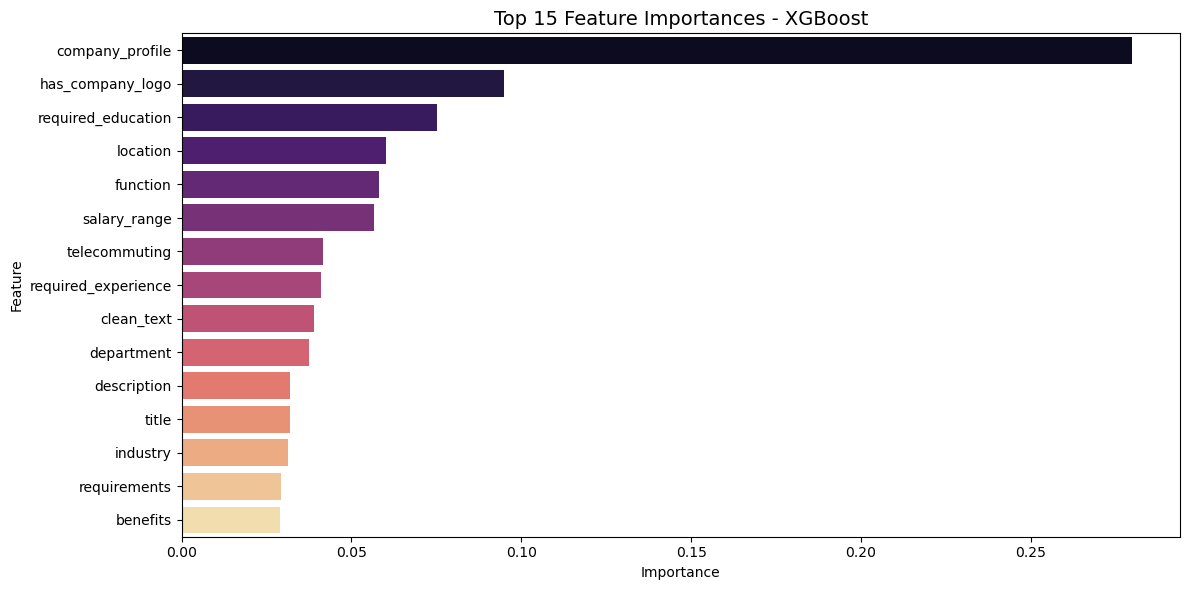

In [18]:
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='magma')
plt.title("Top 15 Feature Importances - XGBoost", fontsize=14)
plt.tight_layout()
plt.show()

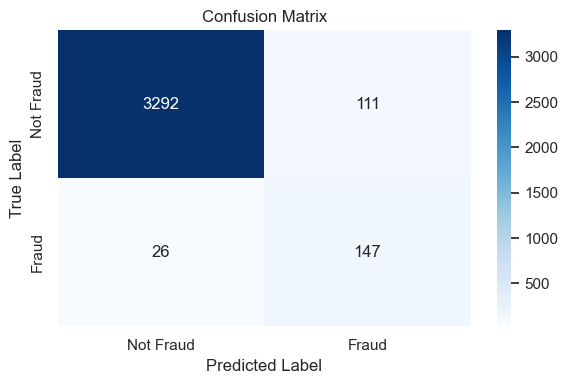

In [22]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

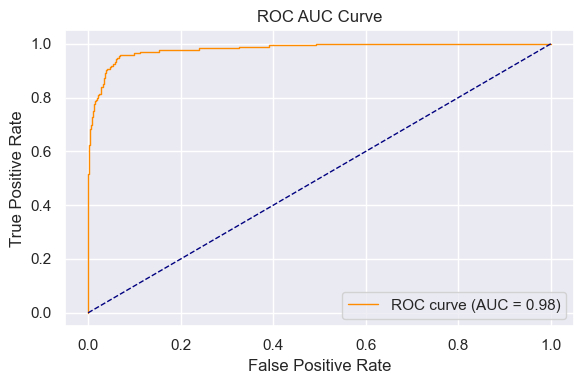

In [26]:
# Get predicted probabilities
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

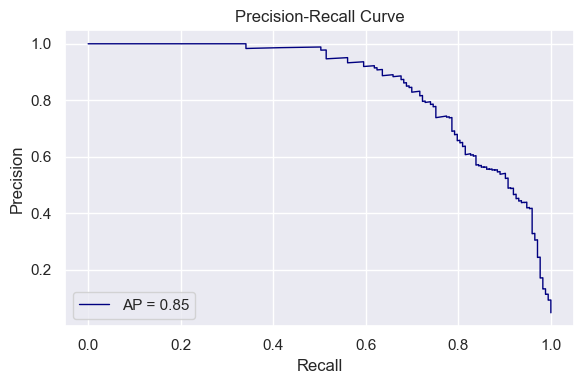

In [30]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='navy', lw=1, label=f'AP = {avg_precision:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [31]:
with open("model_results.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm))

In [32]:
import joblib

# Save model
joblib.dump(xgb_model, 'xgb_fraud_detector.pkl')

['xgb_fraud_detector.pkl']

In [33]:
def predict_fraud(new_data):
    new_vector = preprocessor.transform(new_data)  # If you used one
    prediction = xgb_model.predict(new_vector)
    return 'Fraudulent' if prediction[0] == 1 else 'Legit'